In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from torchvision import transforms
#from transformers import DeepLabV3Processor, DeepLabV3ForSemanticSegmentation

from PIL import Image
import evaluate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm.notebook import tqdm
import wandb
import segmentation_models_pytorch as smp
#!pip install opencv-python
import cv2

Here we create all datasets for our 3 models

In [2]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "groundtruth")
        self.img_dir = os.path.normpath(self.img_dir)
        self.ann_dir = os.path.normpath(self.ann_dir)
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          if os.path.basename(root) != "images":
            files = [os.path.basename(root) + "/" + f for f in files]
          if os.path.basename(root) == "images":
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          if os.path.basename(root) != "groundtruth":
            files = [os.path.basename(root) + "/" + f for f in files]
          if os.path.basename(root) == "groundtruth":
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        #assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #print(os.path.join(self.ann_dir, self.annotations[idx]))
        image = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB")
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))
        # Convert to tensor
        if self.transform:
          image = self.transform(np.array(image))
          image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        
        # Convert segmentation map to tensor, and ensure it's an integer type
        segmentation_map = torch.tensor(np.array(segmentation_map), dtype=torch.long)/250

        return image, segmentation_map

In [3]:
class SemanticSegmentationDataset2(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "groundtruth")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          if os.path.basename(root) != "images":
            files = [os.path.basename(root) + "/" + f for f in files]
          if os.path.basename(root) == "images":
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          if os.path.basename(root) != "groundtruth":
            files = [os.path.basename(root) + "/" + f for f in files]
          if os.path.basename(root) == "groundtruth":
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [4]:
class SemanticSegmentationDataset3(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "groundtruth")
        self.img_dir = os.path.normpath(self.img_dir)
        self.ann_dir = os.path.normpath(self.ann_dir)

        # Read images
        self.images = sorted([f for f in os.listdir(self.img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        # Read annotations
        self.annotations = sorted([f for f in os.listdir(self.ann_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        ann_path = os.path.join(self.ann_dir, self.annotations[idx])

        resize_transform = transforms.Resize((416, 416))


        image = Image.open(img_path).convert("RGB")
        segmentation_map = Image.open(ann_path)

        image = resize_transform(image)
        segmentation_map = resize_transform(segmentation_map)

        if self.transform:
            image = self.transform(np.array(image))
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        segmentation_map = torch.tensor(np.array(segmentation_map), dtype=torch.long) / 250

        return image, segmentation_map

Load our 3 models

In [5]:
ENCODER = "resnet34"  # Example encoder
ENCODER_WEIGHTS = "imagenet"  # Use ImageNet pretraining weights
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=2,  # Number of classes (including background)
    activation= None  # or 'sigmoid' for binary segmentation
)

model_unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=2,  # Number of classes (including background)
    activation="sigmoid"  # or 'sigmoid' for binary segmentation
)

model_segform = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=2,
)

#Load seg former
model_path = "./models/finetuned_segformer_15_geocropdeg.pth" 
model_segform.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print(f"Model state dict loaded from {model_path}")
    
#Load Unet
model_path = "./models/unet.pth" 
model_unet.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print(f"Model state dict loaded from {model_path}")

#Load Deeplab
model_path = "./models/finetuned_final_34_Deeplab.pth" 
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print(f"Model state dict loaded from {model_path}")

root_dir = './data'
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, train=False, transform=preprocessing_fn)
print("Number of validation examples:", len(valid_dataset))


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model state dict loaded from ./models/finetuned_segformer_15_geocropdeg.pth
Model state dict loaded from ./models/unet.pth
Model state dict loaded from ./models/finetuned_final_34_Deeplab.pth
Number of validation examples: 20


Here is the dataset/dataloader for the transformer

In [6]:
image_processor = SegformerImageProcessor(reduce_labels=False, do_resize=False)
valid_dataset_2 = SemanticSegmentationDataset2(root_dir=root_dir, image_processor=image_processor, train=False)

# Build validation dataloader
batch_size = 1
valid_dataloader = DataLoader(valid_dataset_2, batch_size=batch_size)

Evaluation of transformer on val set

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_segform.eval()  # Set model to evaluation mode
validation_loss = 0.0
all_preds_seg = []
all_labels = []
preds_images_seg = []
with torch.no_grad():
    for val_batch in tqdm(valid_dataloader, desc="Validation"):
        # Get the inputs
        pixel_values = val_batch["pixel_values"].to(device)
        labels = val_batch["labels"].div(255).round().long().to(device)
        # labels = torch.where(val_batch["labels"] == 255, 0, 1).to(device)

        # Forward pass
        outputs = model_segform(pixel_values=pixel_values, labels=labels)
        val_loss, logits = outputs.loss, outputs.logits
        validation_loss += val_loss.item()

        # Evaluate validation metrics
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        predicted = predicted.cpu().numpy().astype(np.uint8)
        # Collect predictions and labels for F1 score
        preds_images_seg.append(predicted)
        all_preds_seg.append(predicted.flatten())
        all_labels.append(labels.cpu().numpy().flatten())

all_preds_seg = np.concatenate(all_preds_seg)
all_labels = np.concatenate(all_labels)
preds_images_seg = np.concatenate(preds_images_seg)
pixelwise_f1_val = f1_score(all_labels, all_preds_seg, average="binary")
print(pixelwise_f1_val)
rs1 = recall_score(all_labels, all_preds_seg)
print("Recall: ", rs1)
precision_s = precision_score(all_labels, all_preds_seg)
print("Precision", precision_s)
acc = accuracy_score(all_labels, all_preds_seg)
print("Accuracy", acc)
preds_images_seg = (preds_images_seg * 255).astype(np.uint8)

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

0.8765916516078075
Recall:  0.8642055602011005
Precision 0.8893379490580613
Accuracy 0.948439375


Evaluation of DeepLabV3+ on val set

In [8]:
batch_size = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds = []
all_labels = []
preds_images_dl = []
labels_images = []
model.eval()  # Set model to evaluation mode
validation_loss = 0.0
kernel = np.ones((4,4), np.uint8)
with torch.no_grad():
    for val_batch in tqdm(valid_dataloader, desc="Validation"):
        # Get the inputs
        image, mask = val_batch
        #print("Shape", image.shape)
        image = image.to(device)
        mask = mask.to(device)
        # Forward pass
        outputs = model(image)
        one_part = outputs[:, 1, :, :]
        val_loss = nn.BCEWithLogitsLoss()(one_part, mask)
        validation_loss += val_loss.item()
        # Evaluate validation metrics
        predicted = outputs.argmax(dim=1)

        all_preds.append(predicted.cpu().numpy().flatten())
        labels_images.append(mask.cpu().numpy())
        preds_images_dl.append(predicted.cpu().numpy())
        all_labels.append(mask.cpu().numpy().flatten())

# Compute overall metrics for validation
avg_val_loss = validation_loss / len(valid_dataloader)
# Compute pixel-wise scores for the entire validation set
all_preds = np.concatenate(all_preds)
preds_images_dl = np.concatenate(preds_images_dl)
all_labels = np.concatenate(np.round(all_labels).astype(int))
labels_images = np.concatenate(np.round(labels_images).astype(int))
assert len(all_preds) == len(all_labels)

pixelwise_f1_val = f1_score(all_labels, all_preds, average="binary")
print(pixelwise_f1_val)
rs1 = recall_score(all_labels, all_preds)
print("Recall: ", rs1)
prec_score = precision_score(all_labels, all_preds)
print("Precision: ", prec_score)
acc_score = accuracy_score(all_labels, all_preds)
print("Accuracy: ", acc_score)
preds_images_dl = (preds_images_dl * 255).astype(np.uint8)
labels_images = (labels_images * 255).astype(np.uint8)


Validation:   0%|          | 0/20 [00:00<?, ?it/s]

0.8608158441952152
Recall:  0.8621327999834925
Precision:  0.8595029057166578
Accuracy:  0.94088875


Evaluation of Unet on val set

In [9]:
valid_dataset3 = SemanticSegmentationDataset3(root_dir=root_dir, transform=preprocessing_fn, train=False)
#print("Number of validation examples:", len(valid_dataset))

batch_size = 1
valid_dataloader = DataLoader(valid_dataset3, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds_unet = []
preds_images_unet = []
model_unet.eval()  # Set model to evaluation mode
validation_loss = 0.0
kernel = np.ones((4,4), np.uint8)
with torch.no_grad():
    for val_batch in tqdm(valid_dataloader, desc="Validation"):
        # Get the inputs
        image, mask = val_batch
        #print("Shape", image.shape)
        image = image.to(device)
        mask = mask.to(device)
        # Forward pass
        outputs = model_unet(image)
        one_part = outputs[:, 1, :, :]
        val_loss = nn.BCEWithLogitsLoss()(one_part, mask)
        validation_loss += val_loss.item()
        # Evaluate validation metrics
        predicted = outputs.argmax(dim=1)
        resize_transform = transforms.Resize((400, 400))
        predicted = resize_transform(predicted)

        all_preds_unet.append(predicted.cpu().numpy().flatten())
        preds_images_unet.append(predicted.cpu().numpy())

# Compute overall metrics for validation
avg_val_loss = validation_loss / len(valid_dataloader)
# Compute pixel-wise scores for the entire validation set
all_preds_unet = np.concatenate(all_preds_unet)
preds_images_unet = np.concatenate(preds_images_unet)
assert len(all_preds_unet) == len(all_labels)

pixelwise_f1_val = f1_score(all_labels, all_preds_unet, average="binary")
print(pixelwise_f1_val)
rs1 = recall_score(all_labels, all_preds_unet)
print("Recall: ", rs1)
rs2 = precision_score(all_labels, all_preds_unet)
print("Precision: ", rs2)
rs3 = accuracy_score(all_labels, all_preds_unet)
print("Accuracy: ", rs3)

preds_images_unet = (preds_images_unet * 255).astype(np.uint8)

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

0.8148042582906981
Recall:  0.7584110930478319
Precision:  0.8802575599208298
Accuracy:  0.926903125


Here a quick visualization of all our models

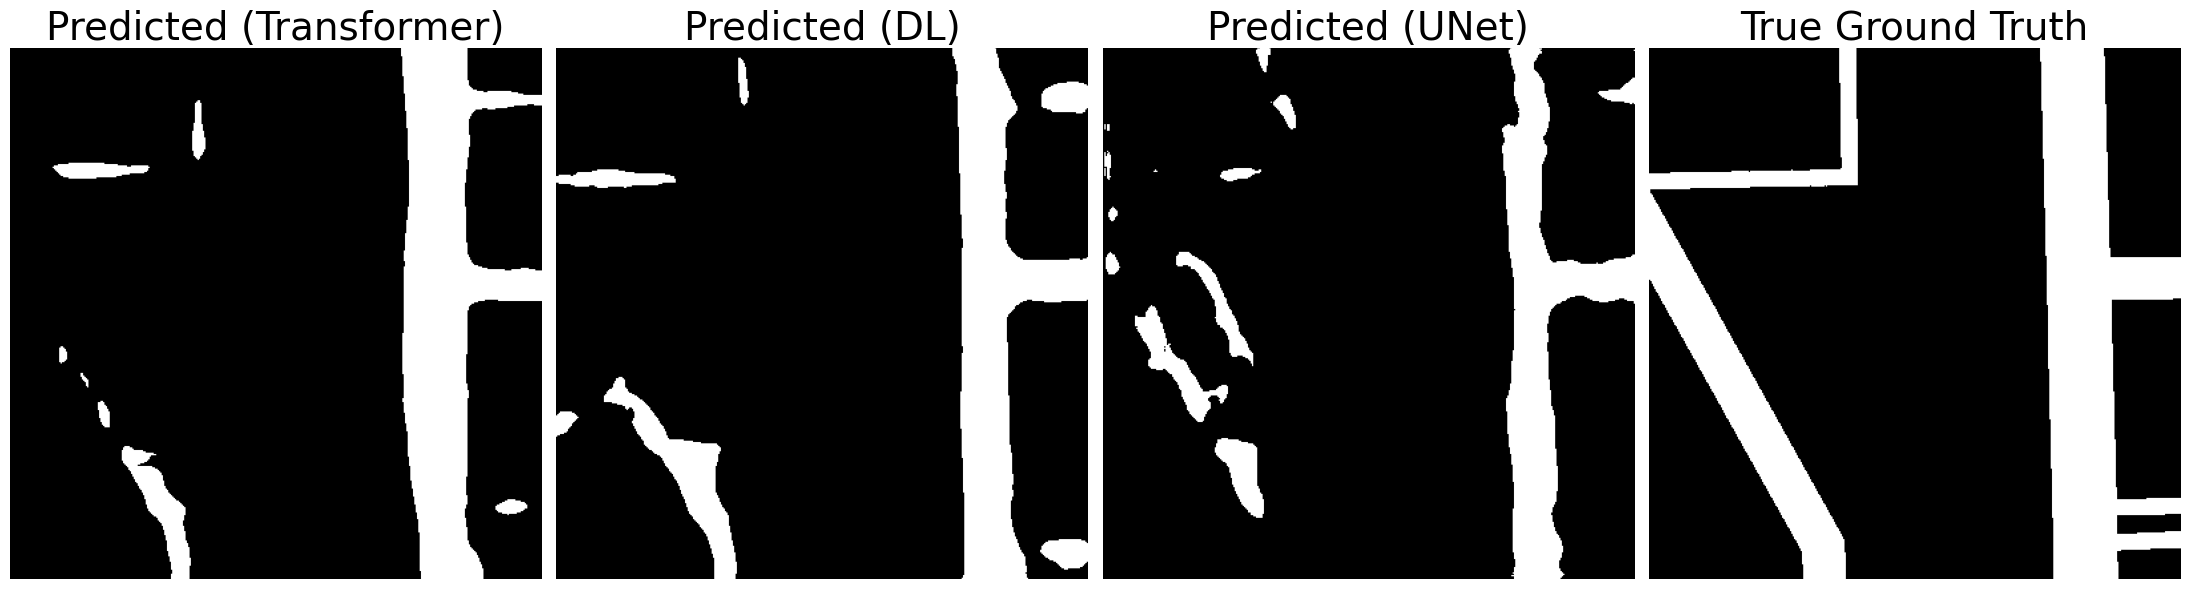

In [10]:
im_nbr = 7
predicted_image_dl = Image.fromarray(preds_images_dl[im_nbr], mode='L')
#predicted_image_dl.show()
true_groundtruth_image  = Image.fromarray(labels_images[im_nbr], mode='L')
#true_groundtruth_image.show()
predicted_image_seg = Image.fromarray(preds_images_seg[im_nbr], mode='L')
#true_groundtruth_image.show()
predicted_image_unet = Image.fromarray(preds_images_unet[im_nbr], mode='L')
#true_groundtruth_image.show()

# Define padding size and color
padding_size = 0  # Adjust as needed
padding_color = 0  # Assuming grayscale; for RGB, use (255, 255, 255)

# Convert images to arrays
images = [
    np.array(predicted_image_seg), 
    np.array(predicted_image_dl), 
    np.array(predicted_image_unet), 
    np.array(true_groundtruth_image)
]

images_with_padding = [
    np.pad(img, 
           ((0, 0), (0, padding_size), (0, 0)) if img.ndim == 3 else 
           ((0, 0), (0, padding_size)), 
           constant_values=padding_color) 
    for img in images[:-1]
]

# Define labels for each image
labels = ['Predicted (Transformer)', 'Predicted (DL)', 'Predicted (UNet)', 'True Ground Truth']

# Append the last image without extra padding
images_with_padding.append(images[-1])

# Plot the images with Matplotlib
fig, axes = plt.subplots(1, len(images_with_padding), figsize=(22, 8))

for ax, img, label in zip(axes, images_with_padding, labels):
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.set_title(label, fontsize=28)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [12]:
#Majority voting for the images with 0/255 pixels
def majority_voting_images(img1, img2, img3):
    # Stack images into a 3D array
    images = np.stack((img1, img2, img3))

    # Perform majority voting
    majority_vote = np.sum(images, axis=0) > 255

    # Convert boolean to integer (optional)
    majority_vote = majority_vote.astype(int)

    return majority_vote

In [13]:
#Majority voting for the images with 0/1 pixels
def majority_voting_array(img1, img2, img3):
    # Stack images into a 3D array
    images = np.stack((img1, img2, img3))

    # Perform majority voting
    majority_vote = np.sum(images, axis=0) > 1

    # Convert boolean to integer (optional)
    majority_vote = majority_vote.astype(int)

    return majority_vote

In [14]:
all_preds_maj = majority_voting_images(predicted_image_dl, predicted_image_seg, predicted_image_unet)
all_preds_maj_im = (all_preds_maj * 255).astype(np.uint8)
predicted_maj_im = Image.fromarray(all_preds_maj_im, mode='L')
predicted_maj_im.show()

In [15]:
all_preds_maj = majority_voting_array(all_preds, all_preds_unet, all_preds_seg)

Here we evaluate how well majority voting performed on val set

In [16]:
all_preds_maj = majority_voting_array(all_preds, all_preds_unet, all_preds_seg)
pixelwise_f1_val = f1_score(all_labels, all_preds_maj, average="binary")
print(pixelwise_f1_val)
rs1 = recall_score(all_labels, all_preds_maj, average="binary")
print("Recall better: ", rs1)
precision_s = precision_score(all_labels, all_preds_maj)
print("Precision", precision_s)
acc = accuracy_score(all_labels, all_preds_maj)
print("Accuracy", acc)

0.8725666386471181
Recall better:  0.8483622927165027
Precision 0.8981926789609854
Accuracy 0.9474609375


In [17]:
model.eval() 
model_unet.eval()
model_segform.eval()
image_processor = SegformerImageProcessor(reduce_labels=False, do_resize=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = "./data/test"
images = sorted(os.listdir(path))
print(images)
outputs = []
outputs_unet = []
outputs_segform = []
output_maj = []
for im in images:
    print(im)
    # Open the image
    image = Image.open(f"./data/test/{im}/{im}.png").convert("RGB")
    #print(f"{path}/{im}")
    image_prep = preprocessing_fn(np.array(image))
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
    image_prep = torch.tensor(image_prep, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    with torch.no_grad():
        #Take output from deeplab
        output_deeplab = model(image_prep)
        output_deeplab = output_deeplab.argmax(dim=1)
        output_deeplab = output_deeplab.numpy().astype(np.uint8)

        #Take output from deeplab
        output_unet = model_unet(image_prep)
        output_unet = output_unet.argmax(dim=1)
        output_unet = output_unet.numpy().astype(np.uint8)

        #Output for segform
        output_segform = model_segform(pixel_values=pixel_values)

    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(output_segform, target_sizes=[image.size[::-1]])[0]
    predicted_segmentation_map = predicted_segmentation_map.mul(255)
    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
    predicted_segmentation_map = predicted_segmentation_map.astype(np.uint8)
    outputs_segform.append(predicted_segmentation_map)

    #deeplab
    array_scaled_deeplab = (output_deeplab[0]* 255).astype(np.uint8)
    image_deeplab = Image.fromarray(array_scaled_deeplab, mode='L')  # 'L' mode for grayscale
    #image.save(f"./data/test/{im}/{im}_deeplab.png")
    outputs.append(array_scaled_deeplab)

    #unet
    array_scaled_unet = (output_unet[0]* 255).astype(np.uint8)
    image_deeplab = Image.fromarray(array_scaled_unet, mode='L')  # 'L' mode for grayscale
    #image.save(f"./data/test/{im}/{im}_deeplab.png")
    outputs_unet.append(array_scaled_unet)

    array_maj = majority_voting_images(predicted_segmentation_map, array_scaled_deeplab, array_scaled_unet)
    array_maj = (array_maj* 255).astype(np.uint8)
    image_maj = Image.fromarray(array_maj, mode='L') 
    output_maj.append(array_maj)
    image_maj.save(f"./data/test/{im}/{im}_maj_voting.png")


['test_1', 'test_10', 'test_11', 'test_12', 'test_13', 'test_14', 'test_15', 'test_16', 'test_17', 'test_18', 'test_19', 'test_2', 'test_20', 'test_21', 'test_22', 'test_23', 'test_24', 'test_25', 'test_26', 'test_27', 'test_28', 'test_29', 'test_3', 'test_30', 'test_31', 'test_32', 'test_33', 'test_34', 'test_35', 'test_36', 'test_37', 'test_38', 'test_39', 'test_4', 'test_40', 'test_41', 'test_42', 'test_43', 'test_44', 'test_45', 'test_46', 'test_47', 'test_48', 'test_49', 'test_5', 'test_50', 'test_6', 'test_7', 'test_8', 'test_9']
test_1
test_10
test_11
test_12
test_13
test_14
test_15
test_16
test_17
test_18
test_19
test_2
test_20
test_21
test_22
test_23
test_24
test_25
test_26
test_27
test_28
test_29
test_3
test_30
test_31
test_32
test_33
test_34
test_35
test_36
test_37
test_38
test_39
test_4
test_40
test_41
test_42
test_43
test_44
test_45
test_46
test_47
test_48
test_49
test_5
test_50
test_6
test_7
test_8
test_9


In [179]:
from mask_to_submission import masks_to_submission
submission_filename = '_pred_maj_voting.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = f"./data/test/test_{i}/test_{i}_maj_voting.png"
    #print(image_filename)
    image_filenames.append(image_filename)
    #print()
masks_to_submission(submission_filename, *image_filenames)

print("Submission file created. Done!")

Submission file created. Done!
